In [3]:
%load_ext autoreload

%autoreload 2

from models import vgg11_PascalVOC, vgg_preprocess
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import _GradCAMPlusPlus, _DeepLiftShap, cut_model_to_layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = vgg_preprocess

In [5]:
g = nn.Sequential(*list(model.children())[:-2])
h = lambda x : model.classifier(torch.flatten(x, 1))

In [121]:
from tqdm.auto import tqdm
def calculate_erf(model, input, device):
    # input_tensor = torch.zeros(input_shape, device=device, requires_grad=True)
    input_tensor = torch.tensor(input, device=device, requires_grad=True)
    # input_tensor = torch.randn(input_shape, device=device, requires_grad=True)
    # Set the model to evaluation mode
    model.eval()

    # Forward pass: compute the output tensor
    output = model(input_tensor)

    input_shape = input_tensor.shape
    
    # x, y = grad_output.shape[2] // 2, grad_output.shape[3] // 2
    result = np.zeros((output.shape[2], output.shape[3], input_shape[1], input_shape[2], input_shape[3]))
    for x in tqdm(range(output.shape[2])):
        for y in range(output.shape[3]):
            # input_tensor = torch.zeros(input_shape, device=device, requires_grad=True)
            input_tensor = torch.randn(input_shape, device=device, requires_grad=True)
            # input_tensor = torch.ones(input_shape, device=device, requires_grad=True)
            # input_tensor = torch.tensor(input, device=device, requires_grad=True)
            # input_tensor = input.clone().detach().to(device).requires_grad_(True)
            # Set the model to evaluation mode
            model.eval()

            # Forward pass: compute the output tensor
            output = model(input_tensor)
            # Initialize the output gradient as zero everywhere and 1 at a specific location
            grad_output = torch.zeros_like(output)
            
            grad_output[0, :, x, y] = 1  # Target a specific output unit

            # Backward pass: compute gradient of the output with respect to the input image
            output.backward(grad_output, retain_graph=True)

            # Retrieve the gradient of the input
            grad_input = input_tensor.grad.data[0].cpu().numpy()
            grad_input = np.abs(grad_input)  # Get the absolute values of the gradients
            grad_input = grad_input / np.max(grad_input) # Normalize the gradients

            # Save the gradient of the input
            result[x, y] = grad_input

    return result

In [122]:
input_tensor = torch.randn(1,3,224,224)
output_tensor = g(input_tensor)
grad_input = calculate_erf(g, torch.zeros(1,3,224,224), device=device)

C:\Users\Luca\AppData\Local\Temp\ipykernel_936\2265078591.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input, device=device, requires_grad=True)


  0%|          | 0/7 [00:00<?, ?it/s]

In [123]:
output_tensor.shape, grad_input.shape

(torch.Size([1, 512, 7, 7]), (7, 7, 3, 224, 224))

In [137]:
single_output = output_tensor[0,:,3,3]
grad = grad_input[3][3]
print(single_output.shape, grad.shape)

torch.Size([512]) (3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


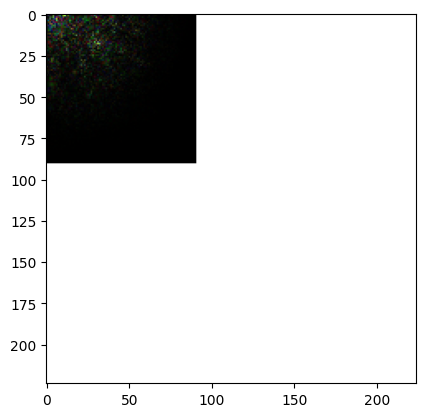

In [125]:
gr = grad.copy()
gr[gr == 0] = 100
plt.imshow(gr.transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


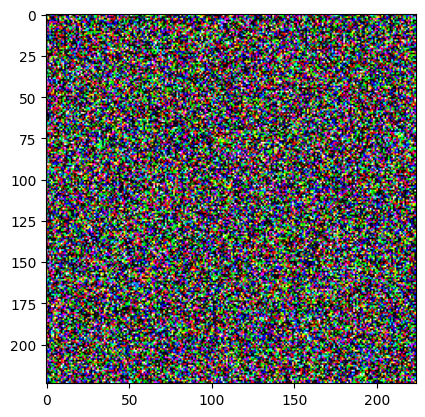

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


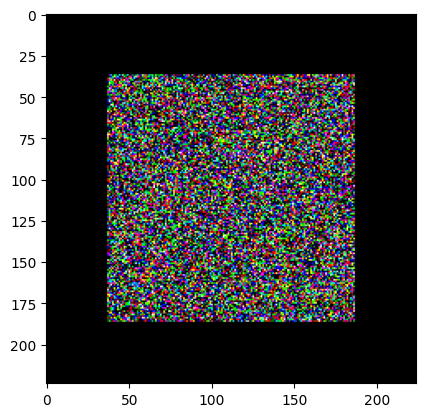

In [138]:
# N = np.arange(20, 150)
# err = []
# for n in N:
# Perturbe only where grad is 0 in order to see if the value does not change
perturbed_input = input_tensor.clone()
plt.imshow(perturbed_input[0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
# zeros = torch.zeros_like(perturbed_input)
# zeros[0,:,:n,:n] = perturbed_input[0,:,:n,:n]
# perturbed_input = zeros
# perturbed_input[0,:,80:,80:] = torch.zeros_like(perturbed_input[0,:,80:,80:])
perturbed_input[0,grad == 0] = torch.zeros_like(perturbed_input[0,grad == 0])
plt.imshow(perturbed_input[0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
output_tensor_perturbed = g(perturbed_input)
single_output_perturbed = output_tensor_perturbed[0,:,3,3]

# err.append(np.linalg.norm(single_output_perturbed.detach().cpu().numpy() - single_output.detach().cpu().numpy()))

In [139]:
np.linalg.norm(single_output_perturbed.detach().cpu().numpy() - single_output.detach().cpu().numpy())

0.0

In [128]:
single_output_perturbed.shape

torch.Size([512])

In [129]:
(single_output - single_output_perturbed).norm()

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

In [130]:
input_tensor1 = torch.zeros(1,3,224,224)
output_tensor1 = g(input_tensor1)
grad_input1 = calculate_erf(g, torch.zeros(1,3,224,224), device=device)

# input_tensor2 = torch.ones(1,3,224,224)
# output_tensor2 = g(input_tensor2)
# grad_input2 = calculate_erf(g, torch.zeros(1,3,224,224), device=device)

C:\Users\Luca\AppData\Local\Temp\ipykernel_936\2265078591.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input, device=device, requires_grad=True)


  0%|          | 0/7 [00:00<?, ?it/s]

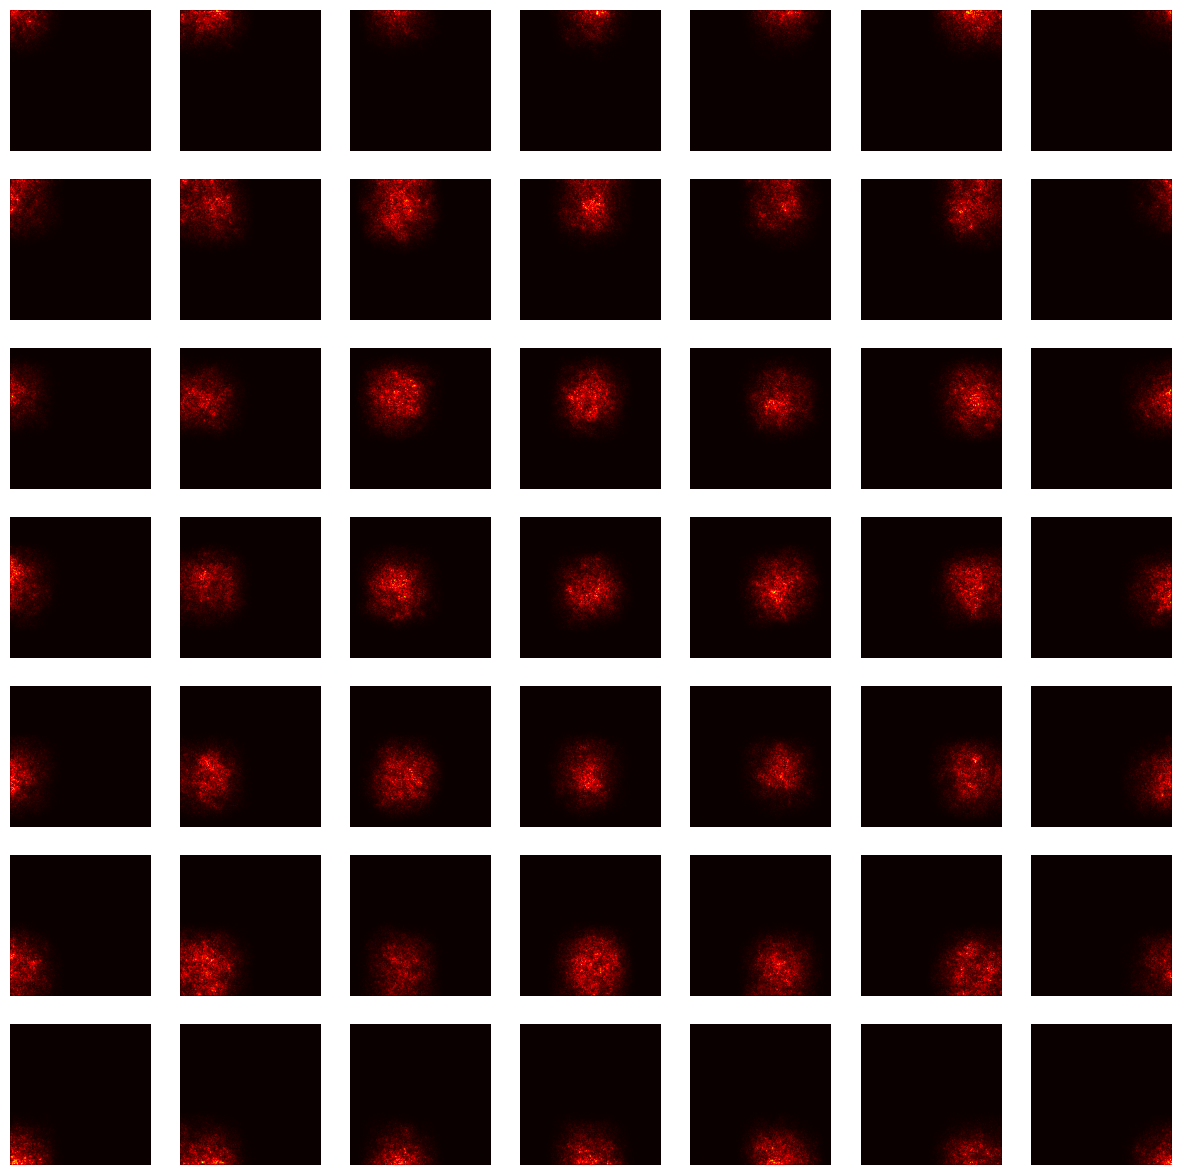

In [132]:
plt.figure(figsize=(15, 15))
for x in range(7):
    for y in range(7):
        plt.subplot(7, 7, x * 7 + y + 1)
        plt.imshow(grad_input[x, y].sum(0), cmap='hot')
        plt.axis('off')

In [133]:
# import dataset
from data import PascalVOC2007

test_data = PascalVOC2007("test", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data


In [134]:
from torch.utils.data import DataLoader, Subset

NUM_IMAGES = 10

test_data_subset = Subset(test_data, np.random.choice(len(test_data), NUM_IMAGES))
test_dl = DataLoader(test_data_subset, batch_size=1, shuffle=True)

In [135]:
def rescale_using_erf(attribution_map, erf_values):
    # attribution_map.shape = (map_H, map_W)
    # erf_values.shape = (map_H, map_W, input_C, input_H, input_W)

    # Rescale the attribution map using the ERF values
    result = np.zeros(erf_values.shape[2:], dtype=np.float32)
    attribution_map = attribution_map.astype(np.float32)

    for i in range(erf_values.shape[0]):
        for j in range(erf_values.shape[1]):
            result += attribution_map[i, j] * erf_values[i, j]
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


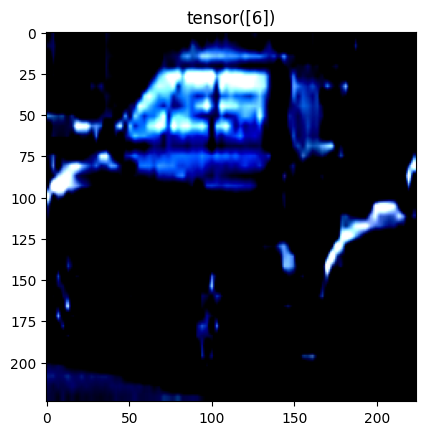

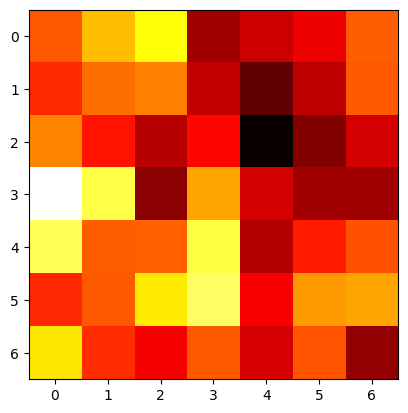

C:\Users\Luca\AppData\Local\Temp\ipykernel_936\2265078591.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input, device=device, requires_grad=True)


  0%|          | 0/7 [00:00<?, ?it/s]

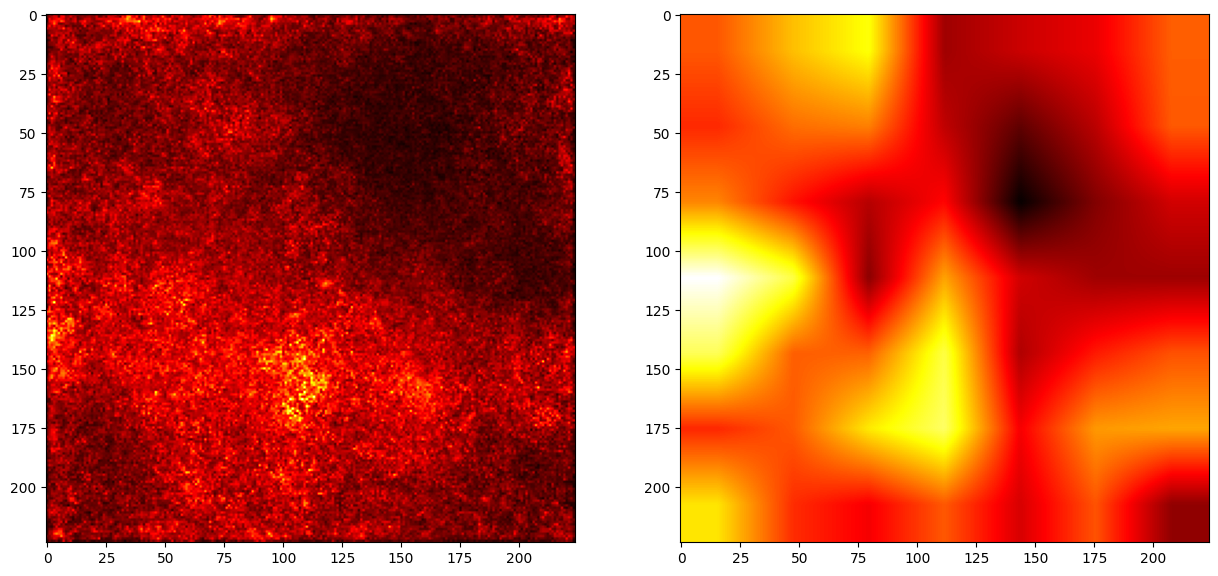

In [141]:
for i in [8]:
    image, label = test_data[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(label)
    plt.show()

    images = image.unsqueeze(0).to(device)
    labels = torch.tensor([label]).to(device)
    layer = [model.features[-1]]

    attribute_method = _GradCAMPlusPlus(model, target_layer=layer[0])
    attributions = attribute_method.attribute(
                    model,
                    input_tensor=images,
                    layer=layer,
                    target=labels,
                    baseline_dist=None,
                )
    
    attributions = attributions[0].cpu().detach().sum(0)

    plt.imshow(attributions.numpy(), cmap='hot')
    plt.show()

    feature_extractor = cut_model_to_layer(model, layer[0], included=True)
    
    erf = calculate_erf(feature_extractor, images, device=device)

    rescaled_attributions_erf = rescale_using_erf(attributions.numpy(), erf)

    up = nn.Upsample(size=images.shape[2:], mode="bilinear")
    rescaled_attributions_bilinear = up(attributions.unsqueeze(0).unsqueeze(0))[0]

    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(rescaled_attributions_erf.sum(0), cmap='hot')

    plt.subplot(1, 2, 2)
    plt.imshow(rescaled_attributions_bilinear.sum(0), cmap='hot')
    plt.show()

